In [2]:
using Plots
using PlotlyJS
using Statistics
using QuadGK
using MAT

In [32]:
vars_q4 = matread("../solutions/Q4data.mat")
time = vars_q4["time"];
Tout = vars_q4["Tout"];
TintRec = vars_q4["TintMeas"];

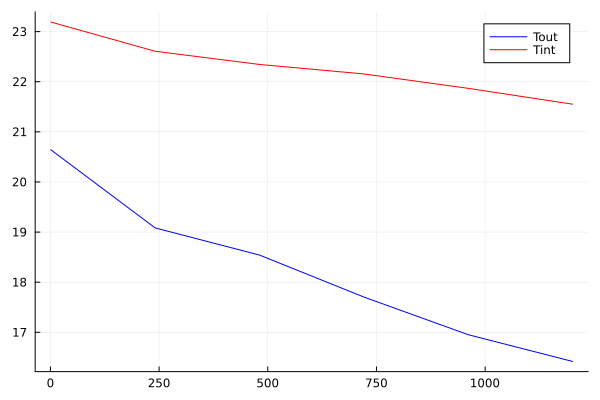

In [33]:
Plots.plot(vec(Tout), label="Tout", linecolor="blue")
Plots.plot!(vec(TintRec), label="Tint", linecolor="red")
# plot!(timing/3600, E_int*ones(length(timing)), label="E_int", linecolor="green")
# plot!(plot_title="E")

In [4]:
# definining constants again, just for completeness and avoid issues..
va      = 2880;     # Volume of air inside the building [m^3]
rhoa    = 1.225;     # Density of air [kg/m^3]
ca      = 1005;      # Specific heat of air [J/KgK]
th      = 0.1;       # Thickness of thermal mass floors[m]
A_f     = 2*90;       # Area of the 3 floors [m^2]
rho_f   = 2300;     # Density of Thermal Mass concrete [kg/m^3]
k_f     = 0.8;         # Conductivity of Thermal Mass concrete [W/mK]
c_f     = 750;        # Specific heat of Thermal Mass concrete [J/KgK]
hconv   = 4;           # Convective heat coefficient [W/m2.K]
Eint    = 250;      # Internal loads due to occupancy, lighting and equipment [W]

## Fabric calculation 

In [6]:
# Discretization variables
dt = 15;
dx = th/10;
x = range(0, th, step = dx)  |> collect 
Nx = length(x)

11

In [7]:
function conductionMatrix(lambda, dt, dx, Nx)
    # used to calculate temperature evolution within a fabric 
    A = zeros(Nx, Nx)

    A[1,1] = 1-lambda;  
    A[1,2] = lambda;
    A[Nx,Nx-1] = lambda;
    A[Nx,Nx] = 1-lambda;  
    
    # all other rows 
    for i = 2:Nx-1
        A[i, i-1] = lambda;
        A[i, i] = 1-2*lambda;
        A[i, i+1] = lambda;
    end

    return A

end

conductionMatrix (generic function with 1 method)

In [8]:
# Matrix for conduction 
alpha = k_f/(rho_f*c_f) # thermal conductivity / (density * specific heat )
lambda = alpha * dt / dx^2
A = conductionMatrix(lambda, dt, dx, Nx);


### initialize data structures for fabric calculation 

In [9]:
# # first loop for thermal mass initial temperature 
# # original, matrix dimensions are wrong though 

# # initialize night flush conditions => convert from clecius to kelvin 
# Tint    = 273+TintRec[1]; 
# T0      = 273+TintRec[1];
# TNx     = 273+TintRec[1]; #
# Tf      = T0 .+ (TNx-T0)*x'/th; # !!! why not just set the fabric temp to T0?? => 1x11 matrix of 296...

In [35]:
# initialize night flush conditions => convert from clecius to kelvin 
err = 0.005
Tint    = 273 .+TintRec; 
T0      = 273 .+TintRec;
TNx     = 273 + err .+TintRec; # change so that Tint isnt 0?  
Tf      = T0 .+ (TNx-T0).* (x .+ err)/th
Tf

11×1201 Matrix{Float64}:
 296.192  296.19   296.187  296.185  …  294.557  294.555  294.554  294.553
 296.193  296.19   296.188  296.185     294.557  294.556  294.554  294.553
 296.193  296.191  296.188  296.186     294.558  294.556  294.555  294.554
 296.194  296.191  296.189  296.186     294.558  294.557  294.555  294.554
 296.194  296.192  296.189  296.187     294.559  294.557  294.556  294.555
 296.195  296.192  296.19   296.187  …  294.559  294.558  294.556  294.555
 296.195  296.193  296.19   296.188     294.56   294.558  294.557  294.556
 296.196  296.193  296.191  296.188     294.56   294.559  294.557  294.556
 296.196  296.194  296.191  296.189     294.561  294.559  294.558  294.557
 296.197  296.194  296.192  296.189     294.561  294.56   294.558  294.557
 296.197  296.195  296.192  296.19   …  294.562  294.56   294.559  294.558

## natural ventilation 

In [11]:
g = 9.81;

In [12]:
function cd_pivot(alpha)
    W=1;
    H=1;
    W_pivot = z -> (1/W^2 + 1/(2*(H-z)*tand(alpha)+sind(alpha)*W).^2) .^(-1/2)
    h = H * (1- cosd(alpha));
    integral, est = quadgk(W_pivot,h,H) #rtol=1e-8 -> error when go to last element of angle array
    A_eff = W*h + integral ;
    Cd0 = 0.611;
    Cd = A_eff / (H*W) * Cd0;   
    
end

cd_pivot (generic function with 1 method)

### windows

In [13]:
# window properties 
w1 = Dict("alpha" => 42, "area" => 1.61, "l" => 11.34)
w1["cd"] = cd_pivot(w1["alpha"])

w2 = Dict("alpha" => 42, "area" => 1.755, "l" => 6.62)
w2["cd"] = cd_pivot(w2["alpha"])

w3 = Dict("alpha" => 42, "area" => 1.755, "l" => 2.07)
w3["cd"] = cd_pivot(w3["alpha"]);

In [36]:
# convert data into kelvin 
time_in_seconds = time*3600;
time_in_hours   = time;
Tout        = 273 .+Tout;
TintReal    = 273 .+TintRec;

## recursive loop - compute ventilation, internal temperature, and fabric temperature..

In [15]:
Q1 = zeros(length(time));
Q2 = zeros(length(time));
Q3 = zeros(length(time));
Q_tot = zeros(length(time));
Env = zeros(length(time));
qconvst = zeros(length(time));
b = zeros(1,Nx)
Eist = zeros(length(time));

In [16]:
print("hi")

hi

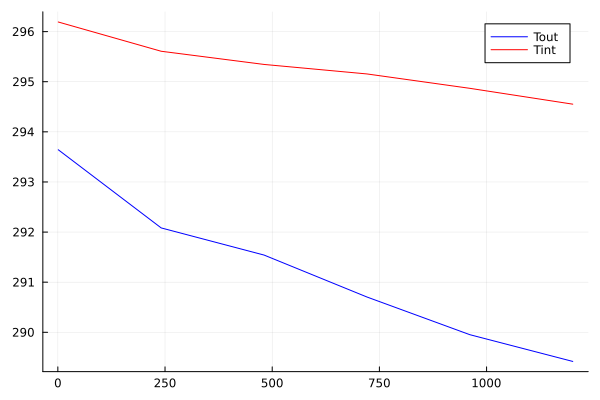

In [37]:
Plots.plot(vec(Tout), label="Tout", linecolor="blue")
Plots.plot!(vec(Tint), label="Tint", linecolor="red")

In [41]:
for t=1:length(time)-1
    # equivalent hour 
    h = time_in_hours[t];
    # print("$t")
    # calculate energy of nat vent at each time step... 
    #Q = \dot{V} => rate of change of volume 
    for (w, Q) in zip([w1, w2, w3], [Q1, Q2, Q3]) 
        # print("$(Tint[t]-Tout[t]) \n")
        Q[t] = w["cd"] * w["area"] * sqrt(2*g*w["l"] * (Tint[t]-Tout[t]) /(Tout[t]+273))
    end
    # print("hi $t, $(Q_tot[t]) \n")
    Q_tot[t] = Q1[t] + Q2[t] + Q3[t]
    # print("t = $t \n Tout length = $(length(Tout)) \n Tint length = $(length(Tint))\n ")
    Env[t] = rhoa * ca * Q_tot[t] * (Tout[t] - Tint[t])


    # convective heat flux
    qconv = hconv* (Tf[1,t] - Tint[t]) # first floor
    # print("qconv $qconv \n") # Tf and Tint are the same...
    qconvst[t] = qconv

    # # wall boundary conditions 
    # # at x = 0 -->
    # # TODO is this getting to the rright place in the matrix??
    b[1] = - lambda * dx / (k_f * qconv)
    b[Nx] = - lambda * dx / (k_f * qconv)

    # # thermal mass temperature 
    Tf[:, t+1] = A*Tf[:,t] + b'

    # TODO work out the math thats happening here...

    # # Air temperature
    Tint[t + 1] = Tint[t] + (qconv*6*A_f + Eint + Env[t])*dt/(va*rhoa*ca)
    Eist[t] = Eint


 end

In [42]:
Q_tot

1201-element Vector{Float64}:
 1.8869243843070151
 1.880449819968928
 1.8682815993486157
 1.856900587061981
 1.846233528759535
 1.8362178990279223
 1.8267999848705896
 1.8179333480627546
 1.8095775917493326
 1.801697373477033
 ⋮
 2.3698145424648374
 2.370144749435752
 2.3704748914189775
 2.370804968416406
 2.371134980431103
 2.3714649274672395
 2.3717948095301424
 2.372124626626107
 0.0

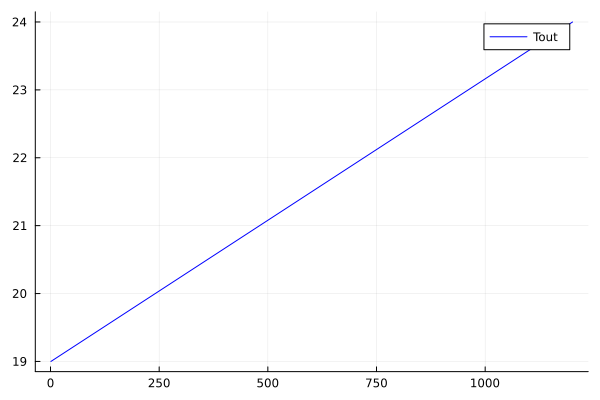

In [45]:
Plots.plot(vec(time_in_hours), label="Tout", linecolor="blue")
# Plots.plot!(vec(Tint), label="Tint", linecolor="red")

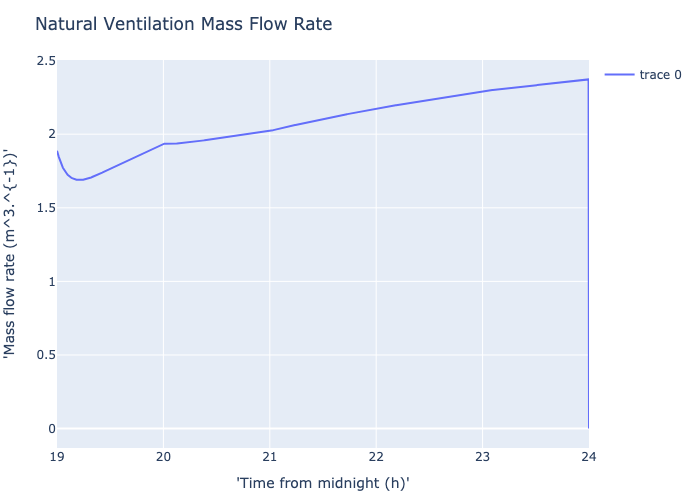

In [48]:
Vnvtot = Q_tot;
t1 = PlotlyJS.scatter(x=vec(time_in_hours),  y=vec(Vnvtot ), mode="lines")
p1 = PlotlyJS.plot([t1],   config=PlotConfig(scrollZoom=false), Layout(;title="Natural Ventilation Mass Flow Rate", showlegend=true, xaxis_title="'Time from midnight (h)'", yaxis_title="'Mass flow rate (m^3.^{-1})'"));
p1

In [54]:
TintReal

1×1201 Matrix{Float64}:
 296.192  296.19  296.187  296.185  …  294.556  294.555  294.554  294.552

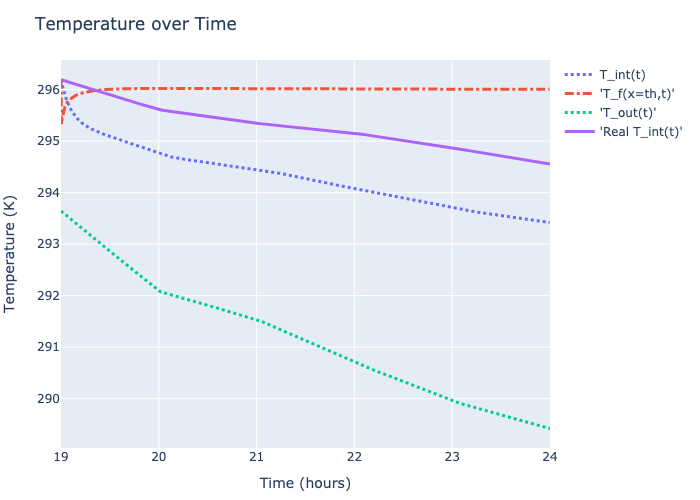

In [57]:
labels = ["T_int(t)","'T_f(x=th,t)'","'T_out(t)'","'Real T_int(t)'"];
vals = [Tint[1:end-1], Tf[end, 1:end-1], vec(Tout), vec(TintReal)]
linewidths = [3,3,3,3]
dashtypes = ["dot", "dashdot", "dot", "none"]


traces = [PlotlyJS.scatter(x=vec(time_in_hours),  y=val, mode="lines", name=label, line=attr(width=lw, dash=dt)) for (val,label, lw, dt) in zip(vals, labels, linewidths, dashtypes)];


p3 = PlotlyJS.plot(traces, Layout(;title="Temperature over Time", showlegend=true, xaxis_title="Time (hours)", yaxis_title="Temperature (K)" ),  config=PlotConfig(scrollZoom=true));
p3